In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import h5py
from helper.general import *
from helper.plotting import *
plt.style.use('seaborn-colorblind')
%matplotlib inline
#  matplotlib.rcParams.update({'font.size': 16})

In [2]:
# Constants
CENTERFREQ = 127710000

In [3]:
# Define signal model
def signal_model(centerFreq_Hz, TE_s, siliconePeak_ppm, FatModel, waterimage, fatimage, siliconeimage,
                 fieldmap_Hz, r2starmap_Hz):
    signal = np.zeros((*waterimage.shape, len(TE_s))).astype(np.complex64)
    for ne, TE in enumerate(TE_s):
        fatphasor = 0.0
        siliconephasor = np.exp(2.0j * np.pi * np.array(siliconePeak_ppm) * centerFreq_Hz * 1e-6 * TE)

        for i, (shift, amp) in enumerate(zip(np.array(FatModel['freqs_ppm']), np.array(FatModel['relAmps']))):
            fatphasor += (amp * np.exp(2.0j * np.pi * shift * centerFreq_Hz * 1e-6 * TE))

        signal[..., ne] = (waterimage + fatimage * fatphasor + siliconeimage * siliconephasor) * \
                           np.exp(2.0j * np.pi * fieldmap_Hz * TE) * \
                           np.exp(-r2starmap_Hz * TE)
    return signal

In [4]:
F = Fatmodel(modelname='Ren marrow')
fatmodel = {}
fatmodel['freqs_ppm'] = F.deshielding_ppm
fatmodel['relAmps'] = F.relamps_percent / 100
silicone_freq_ppm = - 4.9

## Noise performance (Fig. 1)

In [5]:
# Define parameters
delta_TEs = np.linspace(0.1, 3, 300)
num_echoes = [4, 5, 6]
off_TE = 1.58
fatfraction_percent = np.array([0, 50], dtype=np.float32)
siliconefraction_percent = np.array([0, 100], dtype=np.float32)
fatimage = np.repeat(fatfraction_percent[np.newaxis, :, np.newaxis], 2, axis=0)
siliconeimage = np.repeat(siliconefraction_percent[:, np.newaxis, np.newaxis], 2, axis=1)
waterimage = 100 - fatimage
total_species = waterimage + waterimage + siliconeimage

# Calculate NSA for different echo spacings and number of echoes
NSA_fieldmap = np.repeat(np.zeros_like(waterimage)[:,:,:,np.newaxis], len(delta_TEs), axis=-1)
NSA_fieldmap = np.repeat(NSA_fieldmap[..., np.newaxis], len(num_echoes), axis=-1)
NSA_water = np.zeros_like(NSA_fieldmap)
NSA_fat = np.zeros_like(NSA_fieldmap)
NSA_silicone = np.zeros_like(NSA_fieldmap)
for i, delta_TE in enumerate(delta_TEs):
    for k, num_echo in enumerate(num_echoes):
        TE_s = (np.arange(num_echo)*delta_TE+off_TE)*1e-3
        signal = signal_model(CENTERFREQ, TE_s, silicone_freq_ppm, fatmodel, 
                              waterimage=waterimage,
                              fatimage=fatimage,
                              siliconeimage=siliconeimage,
                              fieldmap_Hz=np.zeros_like(waterimage),
                              r2starmap_Hz=40*np.ones_like(waterimage))
        
        in_params = {}
        options = {}
        in_params['TE_s'] = TE_s
        in_params['signal'] = signal
        options['mask'] = np.ones_like(signal, dtype=np.bool_)[..., 0]
        options['init_fieldmap_Hz'] = np.zeros_like(signal, dtype=np.float32)[..., 0]
        options['uncertainty_quant'] = True
        options['pos_constraint'] = False
        options['verbose'] = False
        options['tol'] = 1e-3
        
        out_params = css_silicone(in_params, options)
        NSA_water[..., i, k] = out_params['NSAs'][0, :, :, :]
        NSA_fat[..., i, k] = out_params['NSAs'][2, :, :, :]
        NSA_silicone[..., i, k] = out_params['NSAs'][1, :, :, :]
        NSA_fieldmap[..., i, k] = out_params['NSAs'][6, :, :, :]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


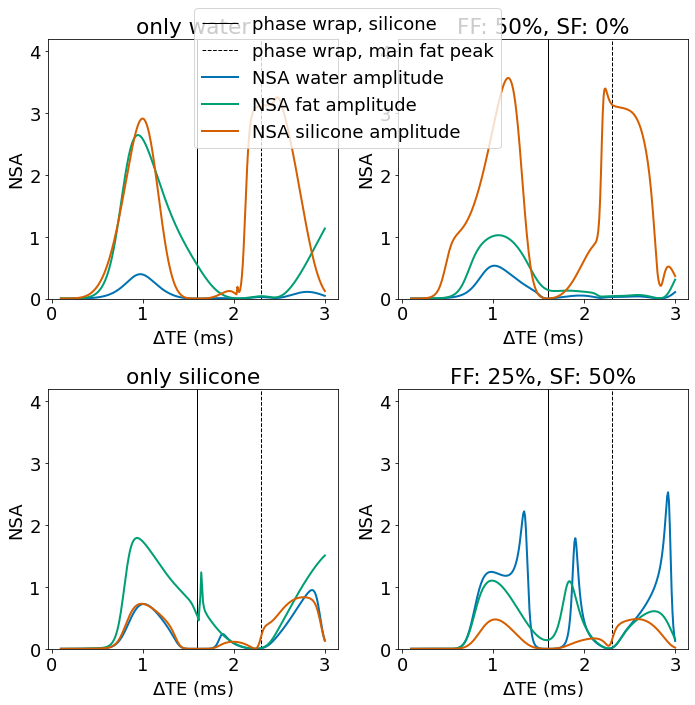

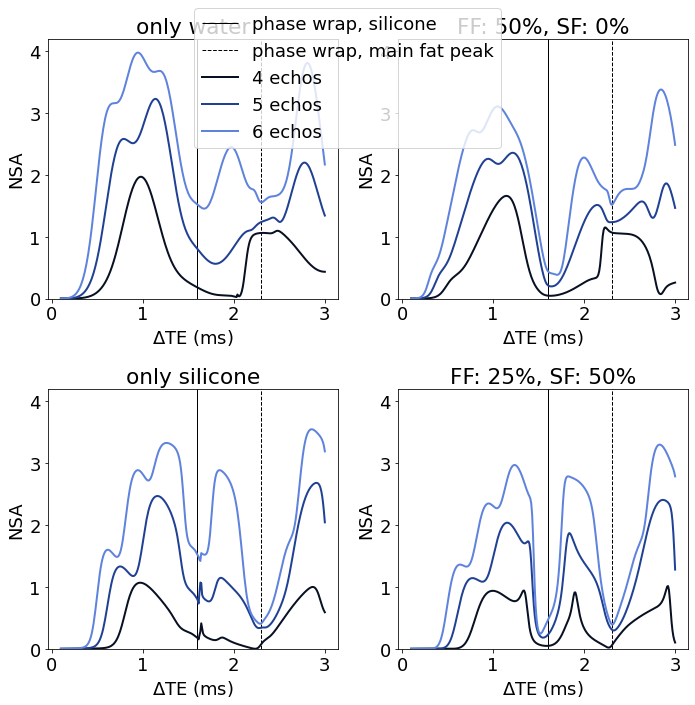

In [6]:
# Plot NSA for 4 echoes
nx, ny = total_species.shape[0:2]
fig_name = 'NSA'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

fig, axs = plot_NSA_template(fatimage, siliconeimage, total_species)
for i in range(nx):
    for j in range(ny):
        voxel = [i, j, 0]
        axs[i, j].plot(delta_TEs, NSA_water[voxel[0], voxel[1], voxel[2], :, 0], 
                       label='NSA water amplitude', linewidth=2)
        axs[i, j].plot(delta_TEs, NSA_fat[voxel[0], voxel[1], voxel[2], :, 0], 
                       label='NSA fat amplitude', linewidth=2)
        axs[i, j].plot(delta_TEs, NSA_silicone[voxel[0], voxel[1], voxel[2], :, 0], 
                       label='NSA silicone amplitude', linewidth=2)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
filename = r'NSA_species'
plt.savefig(f'./figures/{fig_name}/{filename}.eps')

# Plot mean NSA for different number of echoes
color_arr = ['#081023', '#204193', '#5f83dc']
NSA_weighted = (NSA_water+NSA_fat+NSA_silicone)/3
fig, axs = plot_NSA_template(fatimage, siliconeimage, total_species)
for i in range(nx):
    for j in range(ny):
        voxel = [i, j, 0]
        for k in range(len(num_echoes)):
            axs[i, j].plot(delta_TEs, NSA_weighted[voxel[0], voxel[1], voxel[2], :, k], 
                           
                   linewidth='2', color=color_arr[k], label=f'{num_echoes[k]} echos')
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
filename = r'NSA_numberOfechoes'
plt.savefig(f'./figures/{fig_name}/{filename}.eps')

## VARPRO residuals and signal models (Fig. 2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


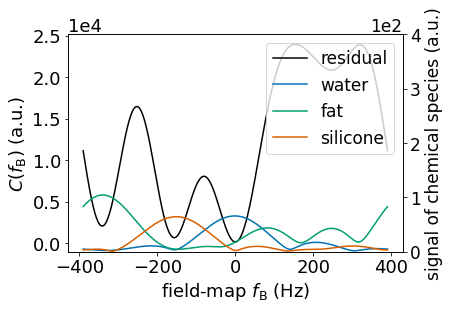

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


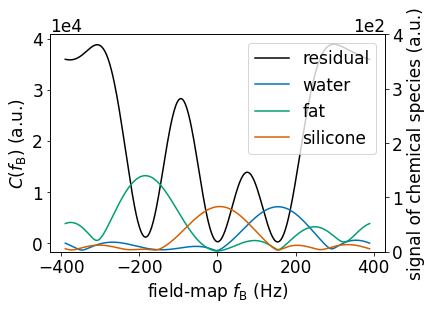

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


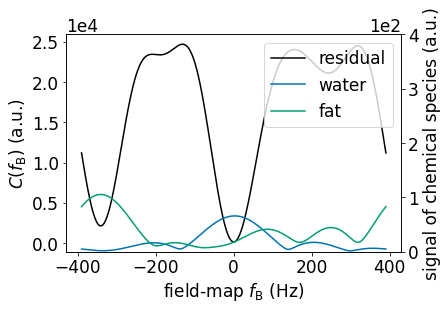

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


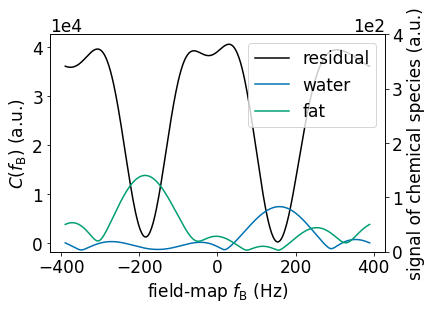

In [7]:
TE_s = 0.0015786 + np.arange(6)*0.0012818
signal = signal_model(CENTERFREQ, TE_s, silicone_freq_ppm, fatmodel, 
                      waterimage=np.array([[[80, 0]]]),
                      fatimage=np.array([[[20, 0]]]),
                      siliconeimage=np.array([[[0, 100]]]),
                      fieldmap_Hz=np.array([[[0, 0]]]),
                      r2starmap_Hz=np.array([[[40, 40]]]))
signal = add_rician_noise(signal, SNR=100)
# Voxel size is just a dummy parameter
params = {'TE_s': TE_s, 'voxelSize_mm': [0.8, 0.8, 0.8], 'fieldStrength_T': 3, 'FatModel': fatmodel, 
          'centerFreq_Hz': CENTERFREQ, 'siliconePeak_ppm': silicone_freq_ppm, 
          'signal_model': 'WFS'}

fig_name = 'residual_model'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

# Voxel 0: 20% FF, no silicone; voxel 1: pure silicone
# Signal model WFS
plot_VARPROvoxel(signal, params, voxel=[0,0,0], plot_components=True, filename='residual_WFS_20FF_0S', 
                 fig_name=fig_name)
plot_VARPROvoxel(signal, params, voxel=[0,0,1], plot_components=True, filename='residual_WFS_0FF_100S', 
                 fig_name=fig_name)

# Signal model WF
params['signal_model'] = 'WF'
plot_VARPROvoxel(signal, params, voxel=[0,0,0], plot_components=True, filename='residual_WF_20FF_0S', 
                 fig_name=fig_name)
plot_VARPROvoxel(signal, params, voxel=[0,0,1], plot_components=True, filename='residual_WF_0FF_100S', 
                 fig_name=fig_name)

## VARPRO residuals and downsampling (Fig. 3)

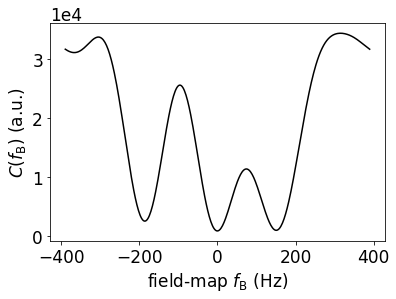

In [8]:
signal = signal_model(CENTERFREQ, TE_s, silicone_freq_ppm, fatmodel, 
                      waterimage=np.array([[[80, 0]]]),
                      fatimage=np.array([[[20, 0]]]),
                      siliconeimage=np.array([[[0, 100]]]),
                      fieldmap_Hz=np.array([[[0, 0]]]),
                      r2starmap_Hz=np.array([[[40, 40]]]))
signal = add_rician_noise(signal, SNR=10)
params = {'TE_s': TE_s, 'voxelSize_mm': [0.8, 0.8, 0.8], 'fieldStrength_T': 3, 'FatModel': fatmodel, 
          'centerFreq_Hz': CENTERFREQ, 'siliconePeak_ppm': silicone_freq_ppm, 
          'signal_model': 'WFS'}

fig_name = 'residual_downsampling'
os.makedirs(f'./figures/{fig_name}', exist_ok=True)

# 6 echoes
plot_VARPROvoxel(signal, params, voxel=[0,0,1], plot_components=False, 
                 filename='residual_WFS_0FF_100S_6echoes', fig_name=fig_name, limit_ylim=False)

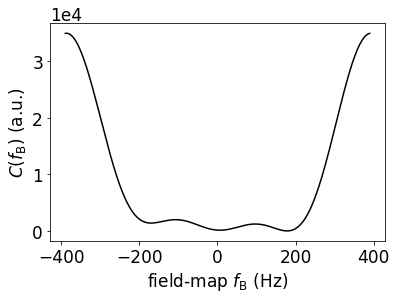

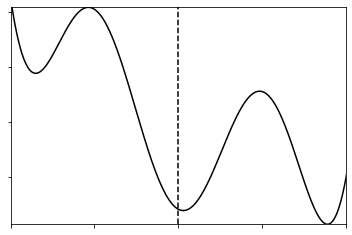

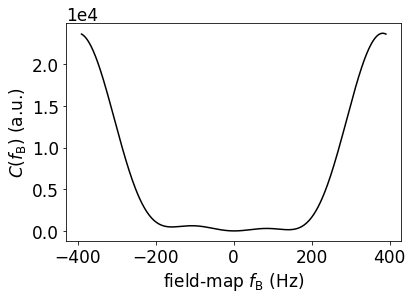

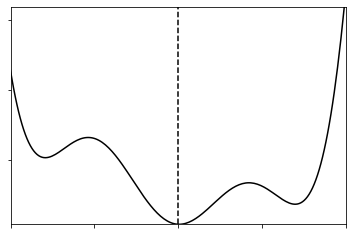

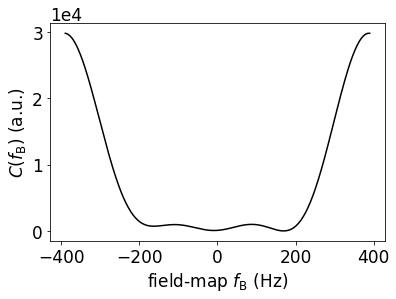

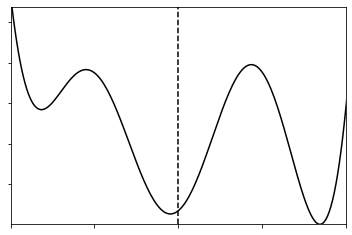

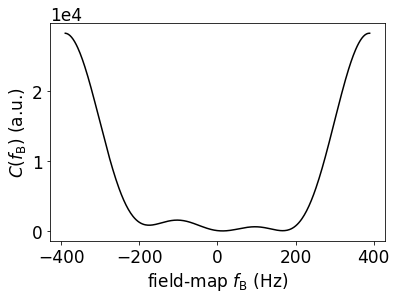

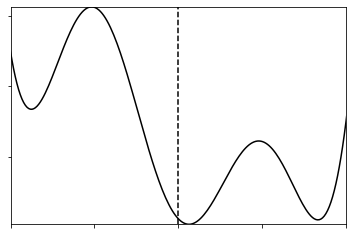

In [9]:
refsignal = signal_model(CENTERFREQ, TE_s[:4], silicone_freq_ppm, fatmodel, 
                         waterimage=np.array([[[80, 0]]]),
                         fatimage=np.array([[[20, 0]]]),
                         siliconeimage=np.array([[[0, 100]]]),
                         fieldmap_Hz=np.array([[[0, 0]]]),
                         r2starmap_Hz=np.array([[[40, 40]]]))
params = {'TE_s': TE_s[:4], 'voxelSize_mm': [0.8, 0.8, 0.8], 'fieldStrength_T': 3, 'FatModel': fatmodel, 
          'centerFreq_Hz': CENTERFREQ, 'siliconePeak_ppm': silicone_freq_ppm, 
          'signal_model': 'WFS'}

signals = np.zeros((4, *refsignal.shape), dtype=np.complex64)
for i in range(4):
    signals[i] = add_rician_noise(refsignal, SNR=10)
    # 4 echoes (4 plots to show influence of noise)
    filename = f'residual_WFS_0FF_100S_4echoes_{i}'
    plot_VARPROvoxel(signals[i], params, voxel=[0,0,1], plot_components=False, filename=filename, fig_name=fig_name, limit_ylim=False)
    plot_VARPROvoxel(signals[i], params, voxel=[0,0,1], plot_components=False, filename=filename, fig_name=fig_name, limit_ylim=False, patch=True)

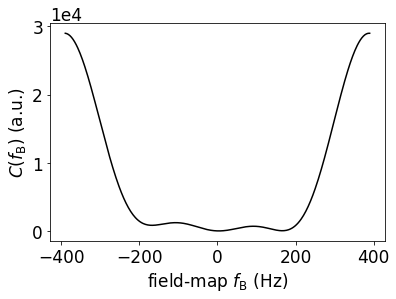

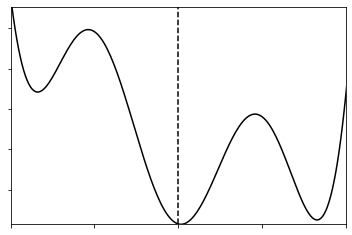

In [10]:
# Averaging:
filename = f'residual_WFS_0FF_100S_4echoes_average'
plot_VARPROvoxel(np.mean(signals, axis=0), params, voxel=[0,0,1], plot_components=False, 
                 filename=filename, fig_name=fig_name, limit_ylim=False)
plot_VARPROvoxel(np.mean(signals, axis=0), params, voxel=[0,0,1], limit_ylim=False, plot_components=False, 
                 filename=filename, fig_name=fig_name, patch=True)